In [2]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import spacy
import random
import math
import time 
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from indicnlp.tokenize import indic_tokenize
from torchtext import data
from torchtext.legacy.data import Field, BucketIterator
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [3]:
df = pd.read_csv('./train.txt', delimiter = "\t", header = None)
df.rename(columns = {0 : 'codemix', 1 : 'english'}, inplace = True)
en_tokenizer = spacy.load('en_core_web_sm')
df

,codemix,english
0,Batman vs Superman,batman vs superman
1,"The director is Zack Snyder, 27% Rotten Tomato...","Zack Snyder director hai, 27% Rotten Tomatoes,..."
2,Not very popular it seems,lagta hai bahut popular nahi hai
3,But the audiences liked it. It has a B cinema ...,"but audience ne like kiya, iska cinema score B..."
4,Yes,yes
...,...,...
8055,Ok.,Thik hai
8056,ok bro,Thik hai bhai
8057,shall we continue?,Kya ham chalu kar sakte hai?
8058,do you like we can,Kya aapko pasand hai hamare saath


In [4]:

# train_temp, test_data_sent = train_test_split(df, test_size = 0.2)
# train_data_sent, validation_data_sent = train_test_split(train_temp, test_size=0.125)
# train_data_sent
# df=df.iloc[:10]
train_data_sent, test_data_sent = train_test_split(df, test_size = 0.2)
validation_data_sent = pd.read_csv('./dev.txt', delimiter = "\t", header = None)
validation_data_sent.rename(columns = {0 : 'codemix', 1 : 'english'}, inplace = True)
# train_data_sent
# validation_data_sent=validation_data_sent.iloc[:5]
validation_data_sent

,codemix,english
0,hello,hello
1,"hello there, I have not seen this movie so im ...","hello yar, mein is movie ko nahi dekha hoon th..."
2,Alright that is fine. What is the movie?,acha tho is movie kis baare me hein?
3,The movie is The Social Network,is movie tho social network ke bare mein hein
4,I have not seen that one either.,mein aise kuch nahi dekha hoon
...,...,...
937,Yep. Thanks for chatting,Yep. Thanks baat karne ke liye
938,"thanks, I will watch it. SOunds good","Thanks, mei dekhati hui. Achi baat hai"
939,Hi!,Hi!
940,Did you like the movie Despicable Me?,kya tumhe movie Despicable Me pasand hai?


In [4]:
train_data_sent.to_json('train_data.json', orient='records', lines=True)
validation_data_sent.to_json('validation_data.json', orient='records', lines=True)
test_data_sent.to_json('test_data.json', orient='records', lines=True)

In [5]:
def hindi_tokenizer(sentence):
    return [word.text for word in en_tokenizer.tokenizer(sentence.strip().split("-")[-1].strip())]    
#     return [word for word in indic_tokenize.trivial_tokenize(sentence.strip().split("-")[-1].strip())]

In [6]:
def english_tokenizer(sentence):
    return [word.text for word in en_tokenizer.tokenizer(sentence.strip().split("-")[-1].strip())]

In [7]:
HINDI = Field(tokenize = hindi_tokenizer, init_token = '<sos>', eos_token = '<eos>' , lower = True)
ENGLISH = Field(tokenize = english_tokenizer, init_token = '<sos>', eos_token = '<eos>', lower = True)
fields = {'english': ('english', ENGLISH), 'hindi': ('hindi', HINDI)}

In [8]:
train_data, validation_data, test_data = data.TabularDataset.splits(path = '',
                                        train = 'train_data.json',
                                        validation = 'validation_data.json',
                                        test = 'test_data.json',
                                        format = 'json',
                                        fields = fields)

print(len(train_data), len(validation_data), len(test_data))

6448 942 1612


In [9]:
# print(train_data_sent)
print(vars(train_data.examples[0]))

{'english': ['sach', 'mein', 'mujhe', 'veh', 'yaad', 'nahi', '..', 'mujhe', 'yaad', 'karwao', 'yeh', 'kahan', 'hui', 'thi'], 'hindi': ['honestly', 'i', 'do', "n't", 'remember', 'that', 'one', '..', 'remind', 'me', 'where', 'exactly', 'it', 'happened']}


In [10]:
ENGLISH.build_vocab(train_data, min_freq=2)
HINDI.build_vocab(train_data, min_freq=2)

print(f"English: {len(ENGLISH.vocab)}, Hindi: {len(HINDI.vocab)}")

English: 4064, Hindi: 3178


In [11]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, p):
        super().__init__()
        self.dropout = nn.Dropout(p)
        self.word_embeddings = nn.Embedding(input_size, embedding_size) 
        self.gru = nn.GRU(embedding_size, hidden_size, bidirectional=True)
        self.linear = nn.Linear(2 * hidden_size, hidden_size)
        self.hidden_size = hidden_size
        
    def forward(self, input):
        embeddings = self.dropout(self.word_embeddings(input))
        o, h = self.gru(embeddings) 
        h = torch.tanh(self.linear(torch.cat((h[-2,:,:], h[-1,:,:]), dim = 1)))

        return o, h

In [12]:
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, p, attention):
        super().__init__()
        self.dropout = nn.Dropout(p)
        self.word_embeddings = nn.Embedding(output_size, embedding_size)
        self.gru = nn.GRU(embedding_size + 2 * hidden_size, hidden_size)
        self.linear = nn.Linear(embedding_size + 3 * hidden_size, output_size)
        self.output_size = output_size
        self.attention = attention
        self.hidden_size = hidden_size

    def forward(self, input, h, eo):        
        embeddings = self.dropout(self.word_embeddings(input.unsqueeze(0)))
        alpha = self.attention(h, eo).unsqueeze(1)
        eo = eo.permute(1, 0, 2)
        w = torch.bmm(alpha, eo).permute(1, 0, 2)
        o, h = self.gru(torch.cat((embeddings, w), dim = 2), h.unsqueeze(0))
        predictions = self.linear(torch.cat((o, w, embeddings), dim = 2).squeeze(0))

        return predictions, h.squeeze(0)

In [13]:
class Model(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.device = device
        self.encoder = encoder
        self.decoder = decoder
         
    def forward(self, input, actual):
        
        eo, h = self.encoder(input)
        input = actual[0, :]
        predictions = torch.zeros(actual.shape[0], actual.shape[1], self.decoder.output_size).to(self.device)

        for t in range(1, actual.shape[0]):
            o, h = self.decoder(input, h, eo)
            predictions[t] = o
            predicted = o.argmax(1) 
            input = predicted

        return predictions  

In [14]:
# a = 4
# b = a
# a = 6
# a += 1
# print(a, b)

In [15]:
def train(model, train_data_iterator, optimizer, criterion):
    
    model.train()    
    total_loss = 0
    
    for batch in train_data_iterator:
        input = batch.english
        actual = batch.hindi
        optimizer.zero_grad()
        predictions = model(input, actual)
        vocab_size = predictions.shape[-1]
        predictions = predictions[1:].view(-1, vocab_size)
        actual = actual[1:].view(-1) # flattening the sentence_length x batch_size dimensions because cross entropy loss needs 1d shape and also removing the sos token
        loss = criterion(predictions, actual)
        loss.backward()   
        total_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
    average_loss = total_loss / len(train_data_iterator)
    return average_loss

In [16]:
def evaluate(model, data_iterator, criterion):
    
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in data_iterator:
            input = batch.english
            actual = batch.hindi
            predictions = model(input, actual)
            vocab_size = predictions.shape[-1]
            predictions = predictions[1:].view(-1, vocab_size)
            actual = actual[1:].view(-1) # flattening the sentence_length x batch_size dimensions because cross entropy loss needs 1d shape and also removing the sos token
            loss = criterion(predictions, actual)
            total_loss += loss.item()
    
    average_loss = total_loss / len(data_iterator)
    return average_loss

In [17]:
enc = Encoder(len(ENGLISH.vocab), 350, 512, 0.5)
attention = Attention(512)
dec = Decoder(len(HINDI.vocab), 350, 512, 0.5)

model = Model(enc, dec, device).to(device)
for name, param in model.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
model

Model(
  (encoder): Encoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (word_embeddings): Embedding(4064, 350)
    (lstm): LSTM(350, 512)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (word_embeddings): Embedding(3178, 350)
    (lstm): LSTM(862, 512)
    (linear): Linear(in_features=1374, out_features=3178, bias=True)
  )
)

In [18]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = HINDI.vocab.stoi[HINDI.pad_token])

In [19]:
best_loss = 1e9

train_data_iterator, validation_data_iterator, test_data_iterator = BucketIterator.splits((train_data, validation_data, test_data), batch_size = 64, device = device, sort = False)

training_losses = []
validation_losses = []

for epoch in range(25):
    train_loss = train(model, train_data_iterator, optimizer, criterion)
    valid_loss = evaluate(model, validation_data_iterator, criterion)
    training_losses.append(np.exp(train_loss))
    validation_losses.append(np.exp(valid_loss))
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), 'encoder_decoder.pt')
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    print(f"Train Loss (exponent to analyse better): {np.exp(train_loss):.3f}")
    print(f"Val. Loss (exponent to analyse better): {np.exp(valid_loss):.3f}")

Epoch: 01
	Train Loss: 5.820 | Train PPL: 336.963
	 Val. Loss: 5.402 |  Val. PPL: 221.912
Train Loss (exponent to analyse better): 336.963
Val. Loss (exponent to analyse better): 221.912
Epoch: 02
	Train Loss: 5.585 | Train PPL: 266.489
	 Val. Loss: 5.393 |  Val. PPL: 219.891
Train Loss (exponent to analyse better): 266.489
Val. Loss (exponent to analyse better): 219.891
Epoch: 03
	Train Loss: 5.556 | Train PPL: 258.789
	 Val. Loss: 5.349 |  Val. PPL: 210.436
Train Loss (exponent to analyse better): 258.789
Val. Loss (exponent to analyse better): 210.436
Epoch: 04
	Train Loss: 5.447 | Train PPL: 232.081
	 Val. Loss: 5.308 |  Val. PPL: 201.922
Train Loss (exponent to analyse better): 232.081
Val. Loss (exponent to analyse better): 201.922
Epoch: 05
	Train Loss: 5.382 | Train PPL: 217.463
	 Val. Loss: 5.295 |  Val. PPL: 199.312
Train Loss (exponent to analyse better): 217.463
Val. Loss (exponent to analyse better): 199.312
Epoch: 06
	Train Loss: 5.333 | Train PPL: 206.991
	 Val. Loss: 5.

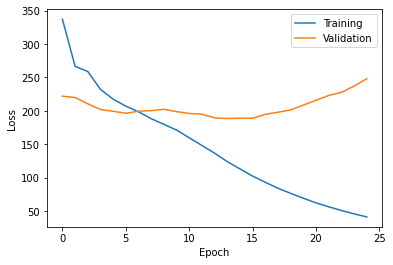

In [20]:
import matplotlib.pyplot as plt

plt.plot(training_losses, label = 'Training')
plt.plot(validation_losses, label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
# def get_tranlsation(text):
#   model.eval()
#   with torch.no_grad():
#     tokens = [token.text.lower() for token in en_tokenizer.tokenizer(text)][::-1]
#     tokens = [ENGLISH.init_token] + tokens + [ENGLISH.eos_token]
#     src_indexes = [ENGLISH.vocab.stoi[token] for token in tokens]
#     src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
#     src_tensor = src_tensor.reshape(-1,1)
#     output = model(src_tensor, src_tensor)
#     output_dim = output.shape[-1]
#     output = output.view(-1, output_dim)
#     indices = torch.argmax(output,dim=1).tolist()
#     return [HINDI.vocab.itos[x] for x in indices]

# print(get_tranlsation("How do you do it?"))

In [22]:
model.load_state_dict(torch.load('encoder_decoder.pt'))
test_loss = evaluate(model, test_data_iterator, criterion)
print(f"Test Loss (exponent to analyse better): {np.exp(test_loss):.3f}")

Test Loss (exponent to analyse better): 163.839


In [23]:
# vars(test_data.examples[2])

In [24]:
def translate(text):
  model.eval()
  with torch.no_grad():
    tokens = english_tokenizer(text)
    tokens = [ENGLISH.init_token] + tokens + [ENGLISH.eos_token]
    src_indexes = [ENGLISH.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_tensor = src_tensor.reshape(-1,1)

    output = model(src_tensor, src_tensor)
    output_dim = output.shape[-1]
    output = output.view(-1, output_dim)
    indices = torch.argmax(output,dim=1).tolist()
    return [HINDI.vocab.itos[x] for x in indices]

print(translate("man speaking native language:"))

['theatrical', 'the', 'is', 'a', '<eos>', '<eos>', '<eos>']


In [25]:
import csv

translated_sentences = open('Paper1.csv','w')
csvwriter = csv.writer(translated_sentences)
csvwriter.writerow(['Input','Predicted','Actual'])  

for i, (eng_sentence, hin_sentence) in enumerate(zip(test_data_sent["english"], test_data_sent["hindi"])):

  hindi_predicted = translate(eng_sentence)
  hindi_predicted = " ".join(list(filter(lambda x: x != '<eos>', hindi_predicted))[1:]).strip()
  csvwriter.writerow([eng_sentence.strip(), hindi_predicted.strip(), hin_sentence.strip()])

  # print(eng_sentence.strip())
  # print(hindi_predicted)
  # print()
  # print()

translated_sentences.close()



In [26]:
with open('Paper1.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            print(f'\t{row[0]} \t \t {row[1]} \t \t {row[2]}.')
            line_count += 1
    print(f'Processed {line_count} lines.')

Column names are Input, Predicted, Actual
	people pasand karenge ki ye unhe smart feel karayega. 	 	 i , i i the the . . . the . 	 	 people would love that it would make them feel smart..
	lol 	 	 i , 	 	 Lol.
	Arre! sahi mein, main sirf Batman vs. Superman. 27% Rotten Tomatoes bilkul sahi hai. 	 	 i , i i the the . . the the . the . the . . . . . 	 	 Hey! Not really, I just Batman vs. Superman. The 27% Rotten Tomatoes score is fitting..
	mein tho abhi bhi kid hey aur mein kaafi remember kartha hoon 	 	 i , . the the the . . the the <unk> . 	 	 I was still a kid back then and I remember liking it a lot.
	shaayad woh funny tha 	 	 i , is the . 	 	 probably that was funny.
	Frank, kamal ka character tha. 	 	 i is is the the <unk> <unk> 	 	 Frank, is quite a character..
	ha ha 	 	 i , 	 	 haha.
	yes mene whole movie dekhi. 	 	 i , i it . the 	 	 Yes I watched the whole movie..
	Jab tak wo mari nahi. Usne rule tode, aur rule to rule hota hai lol 	 	 i is is the the the <unk> . the the <unk

In [1]:
# import csv

# translated_sentences = open('Paper2.csv','w')
# csvwriter = csv.writer(translated_sentences)
# csvwriter.writerow(['Input','Predicted','Actual'])  

import nltk

bleu_i = []
bleu_o = []

for i, (eng_sentence, hin_sentence) in enumerate(zip(test_data_sent["english"], test_data_sent["hindi"])):

  hindi_predicted = translate(eng_sentence)
  hindi_predicted = " ".join(list(filter(lambda x: x != '<eos>', hindi_predicted))[1:]).strip()
  # csvwriter.writerow([eng_sentence.strip(), hindi_predicted.strip(), hin_sentence.strip()])

  bleu_i.append(hin_sentence.strip())
  bleu_o.append(hindi_predicted.strip())

  # print(eng_sentence.strip())
  # print(hindi_predicted)
  # print()
  # print()

# translated_sentences.close()

BLEU_scores = []

for i in range(len(bleu_i)):
  BLEU_scores.append(nltk.translate.bleu_score.sentence_bleu(bleu_i[i], bleu_o[i], smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method7))
  
print("Average BLEU Score:", np.mean(BLEU_scores))



Average BLEU Score: 0.0218309294243317 
